# Text tree edit distance: a language model-based metric for text hierarchy comparison.

This notebook contains the implementation of a simple yet informative metric for text tree comparison. This way of text tree similarity measurement can be used, for example, to compare salient sentence-based mind maps generated by a neural network with reference maps. The way this algorithm works is by applying the Zhang-Shasha algorithm for tree edit distance to text trees, using semantic similarity as the cost of node updates. To measure semantic similarity of sentences in tree nodes, we use a language model's embeddings of the sentences, given the context of all parent nodes if available, and compare these embeddings directly.

The Zhang-Shasha algorithm implementation is taken from the `zss` Python library developed by Tim Henderson and Steve Johnson (2013).

## Prerequisites

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer, SimilarityFunction

from tted.tree_format import Node, tree_with_context, json_to_node
from tted.computation import text_tree_distance, text_tree_distance_w_o_precomputation
from tted.baseline import baseline_distance, baseline_similarity

In [2]:
# Plot formatting
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

We will use text trees stored in the JSON format as in the following example:
```json
{
  "A new algorithm for text tree edit distance based on Zhang-Shasha's algorithm and BERT-like model embedding similarity.": {
    "The algorithm's novelty is in its similarity measure based on BERT-like model embeddings.": {
      "Embedding distance is used as a measure of semantic similarity.": {},
      "The language model allows to capture semantic meaning of sentences and model their similarity.": {}
    },
    "Zhang-Shasha's algorithm is used to compute tree edit distance with new edit costs.": {
      "Semantic similarity is used as the update cost in the algorithm.": {},
      "The costs of insertion and removal of nodes are defined as the similarity of the node and an empty sentence.": {}
    },
    "The proposed algorithm is presented as a more informative metric of similarity between text trees.": {
      "The current ways of comparing text trees overlook their tree structure or the meaning of their labels.": {},
      "This new method can be used, for example, to compare mind maps or hierarchical summaries.": {}
    }
  }
}
```
We use the similarity metric from "Coherence Graph Guidance for Mind-Map Generation" (Zhang et al., 2024) as a baseline for comaprison. The full original code from this paper can be found at https://github.com/Cyno2232/CMGN.

## Basic tests

Below we provide an example use case of the functions above utilizing a model from `sentence_transformers`:

In [3]:
A = (
    Node('We present a new metric for text tree comparison.', depth=0)
        .addkid(Node('It uses Zhang-Shasha\'s algorithm and a BERT-like model.', depth=1)
            .addkid(Node('Zhang-Shasha\'s algorithm is used to measure tree edit distance effectively.', depth=2))
            .addkid(Node('The BERT-like model is used to measure semantic similarity.', depth=2)))
        .addkid(Node('The algorithm is presented as an informative metric for text tree comparison.', depth=1)
            .addkid(Node('There hasn\'t yet been a metric that allows to compare tree-structured text data such as mind maps informatively.', depth=2))
            .addkid(Node('This metric can be used, for example, to evaluate automatic salient sentence-based mind map generation.', depth=2)))
)

B = (
    Node('A new metric for text tree comparison based on tree edit distance and semantic similarity.', depth=0)
        .addkid(Node('Zhang-Shasha\'s algorithm is used to compute tree edit distance.', depth=1))
        .addkid(Node('Semantic similarity is measured using a BERT-like language model.', depth=1)
            .addkid(Node('To measure it, the sentences with all parent nodes as context are passed to the language model.', depth=2))
            .addkid(Node('Semantic similarity is measured as the similarity of the model\'s embeddings of the sentences.', depth=2)))
        .addkid(Node('This metric can be used to compare text trees.', depth=1)
            .addkid(Node('For example, it can be utilized in automatic mind map generation evaluation against reference maps.', depth=2)))
)

In [4]:
model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')
def cos_dist(a_embedding, b_embedding):
        return float(1 - model.similarity(a_embedding, b_embedding))

In [5]:
%%time

AB_dist = text_tree_distance(A, B, model.encode, cos_dist)
print(AB_dist)

3.430862009525299
CPU times: total: 2.64 s
Wall time: 630 ms


In [6]:
%%time

AB_dist = text_tree_distance_w_o_precomputation(A, B, model.encode, cos_dist)
print(AB_dist)

3.4308618903160095
CPU times: total: 2min 19s
Wall time: 17.6 s


In [7]:
%%time

AB_base_dist = baseline_distance(A, B)
print(AB_base_dist)

2.9569458062757326
CPU times: total: 1.38 s
Wall time: 176 ms


## Main experiment

Now we can run a couple of experiments to evaluate these two metrics on simple test cases. We'll compare the methods on three text tree sets, each based on the tree `C` from the example above:
1) A set of trees that are identical in semantic meaning and structure, but the sentences in the tree nodes are paraphrased;
2) A set of trees that are formed from the same sentences, but in different tree order;
3) A set of trees that are similar in structure and wording but significantly different in meaning.

For each set of trees we'll compute pairwise similarity scores with my metric and the baseline method. The goal is to capture the difference in meaning and structure of the trees while minimizing the distance between trees that are, in a sense, paraphrases of each other.

In [8]:
def run_test(method, dist_args=None):
    scores = {}
    test_cases = ['paraphrase', 'meaning', 'structure']

    base_tree = json_to_node('data/tted_test/set_0/base_tree.json')
    total_time = 0
    for test_case in test_cases:
        path = 'data/tted_test/set_0/' + test_case + '_'
        scores[test_case] = []

        trees = []
        sample_count = 10
        for i in range(sample_count):
            trees.append(json_to_node(path + str(i) + '.json'))

        start_time = time.time()
        for i in range(sample_count):
            if method == 'tted':
                scores[test_case].append(text_tree_distance(base_tree, trees[i], *dist_args))
            elif method == 'baseline':
                scores[test_case].append(baseline_distance(base_tree, trees[i]))
            elif method == 'baseline_sim':
                scores[test_case].append(baseline_similarity(base_tree, trees[i]))
            else:
                pass

        total_time += time.time() - start_time

    return scores, total_time

In [9]:
def plot_scores(scores, plot_title, filename):
    fig, ax = plt.subplots(figsize=(7, 5))

    ax.boxplot(scores.values(), vert=False)

    ax.set_xlabel(r'$\rho(T, \cdot)$')
    ax.set_xlim(0)
    ax.set_yticklabels(scores.keys())
    ax.grid()
    if plot_title is not None:
        ax.set_title(plot_title)

    fig.savefig('../img/' + filename, bbox_inches='tight', pad_inches=0.1)

    plt.show()

In [10]:
def result_frame(scores, method_name):
    results_array = [method_name]
    
    for exp in ('paraphrase', 'structure', 'meaning'):
        results_array.append(np.mean(scores[exp]))
        results_array.append(np.std(scores[exp]))
    for exp in ('structure', 'meaning'):
        quality_coeffs = [a / b for a, b in zip(scores['paraphrase'], scores[exp])]
        results_array.append(np.mean(quality_coeffs))
        results_array.append(np.std(quality_coeffs))

    results_array = [results_array]
    frame = pd.DataFrame(results_array, columns=['Method', 
                                                 'Paraphrase mean', 
                                                 'Paraphrase std', 
                                                 'Restructure mean',
                                                 'Restructure std',
                                                 'Meaning mean', 
                                                 'Meaning std', 
                                                 'R_S score',
                                                 'R_S std',
                                                 'R_M score',
                                                 'R_M std'])
    return frame

Below are my experiments with several language models and distance metrics, with and without context usage, in comparison to the baseline method:

In [11]:
scores_dict = {}
times_dict = {}

In [12]:
scores_dict['baseline'], times_dict['baseline'] = run_test('baseline')

In [13]:
baseline_sims, _ = run_test('baseline_sim')

In [14]:
for test_case in ['paraphrase', 'structure', 'meaning']:    
    print(test_case, np.mean(baseline_sims[test_case]), '+-', np.std(baseline_sims[test_case]))

paraphrase 3.9290738080336576 +- 0.29230556402290353
structure 6.952970813228528 +- 0.6727090311830041
meaning 2.637916745672528 +- 0.46072345459338215


In [15]:
for model_name in ['sentence-transformers/paraphrase-distilroberta-base-v1',
              'sentence-transformers/allenai-specter',
              'sentence-transformers/all-mpnet-base-v2',
              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2']:
    model = SentenceTransformer(model_name)

    # The default similarity function for all of the models above is the cosine similarity function
    def dist(a_embedding, b_embedding):
        return float(np.sqrt(1 - model.similarity(a_embedding, b_embedding)))

    dist_args = [model.encode, dist, True]
    scores_dict[model_name], times_dict[model_name] = run_test('tted', dist_args)

In [16]:
# Experiment with different distance measures
for sim_measure, measure_name in zip([SimilarityFunction.EUCLIDEAN, SimilarityFunction.MANHATTAN], ['euclidian', 'manhattan']):
    model.similarity_fn_name = sim_measure
    def dist(embedding_a, embedding_b):
        return float(-model.similarity(embedding_a, embedding_b))
        
    scores_dict[measure_name], times_dict[measure_name] = run_test('tted', [model.encode, dist, True])

In [17]:
# Experiment without context usage
model.similarity_fn_name = SimilarityFunction.COSINE
def dist(a_embedding, b_embedding):
    return float(1 - model.similarity(a_embedding, b_embedding))

dist_args = [model.encode, dist, 1.0, False]
scores_dict['Without context'], times_dict['Without context'] = run_test('tted', dist_args)

In [18]:
times_dict

{'baseline': 14.006042242050171,
 'sentence-transformers/paraphrase-distilroberta-base-v1': 11.391796588897705,
 'sentence-transformers/allenai-specter': 22.07025146484375,
 'sentence-transformers/all-mpnet-base-v2': 24.786922931671143,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 26.737121105194092,
 'euclidian': 25.875531911849976,
 'manhattan': 26.28537893295288,
 'Without context': 10.643398523330688}

In [19]:
frames_dict = {}
for exp_name, method_name in zip(scores_dict.keys(), ['Baseline method',
                                                    'TTED with paraphrase DistilRoBERTa',
                                                    'TTED with SPECTER',
                                                    'TTED with untuned MPNet',
                                                    'TTED with paraphrase MPNet',
                                                    'TTED with MPNet and Euclidian distance',
                                                    'TTED with MPNet and Manhattan distance',
                                                    'TTED with MPNet without context']):
    frames_dict[exp_name] = result_frame(scores_dict[exp_name], method_name)

In [20]:
final_frame = pd.concat(frames_dict.values())
final_frame

,Method,Paraphrase mean,Paraphrase std,Restructure mean,Restructure std,Meaning mean,Meaning std,R_S score,R_S std,R_M score,R_M std
0,Baseline method,3.183293,0.092196,2.259370,0.301532,3.564678,0.131284,1.441157,0.246341,0.893809,0.031820
0,TTED with paraphrase DistilRoBERTa,3.333963,0.228086,7.757944,1.738122,7.382619,0.409480,0.460053,0.138197,0.452809,0.039414
0,TTED with SPECTER,1.390811,0.158311,3.703458,0.810639,4.743490,0.664061,0.401221,0.122279,0.299339,0.057700
0,TTED with untuned MPNet,2.304313,0.327356,7.193196,1.249832,8.063965,0.667664,0.332132,0.081895,0.285588,0.031606
0,TTED with paraphrase MPNet,1.815691,0.222766,7.712809,1.184699,7.558329,0.330694,0.242084,0.049160,0.240284,0.027841
0,TTED with MPNet and Euclidian distance,7.344128,0.915423,29.520249,8.328520,30.221695,1.313955,0.297915,0.190151,0.242952,0.027707
0,TTED with MPNet and Manhattan distance,157.092905,19.867990,621.747075,175.865290,617.628903,27.162866,0.303019,0.194488,0.254392,0.030286
0,TTED with MPNet without context,1.246337,0.099061,4.800517,1.627534,4.344035,0.522070,0.321895,0.189495,0.288809,0.021539


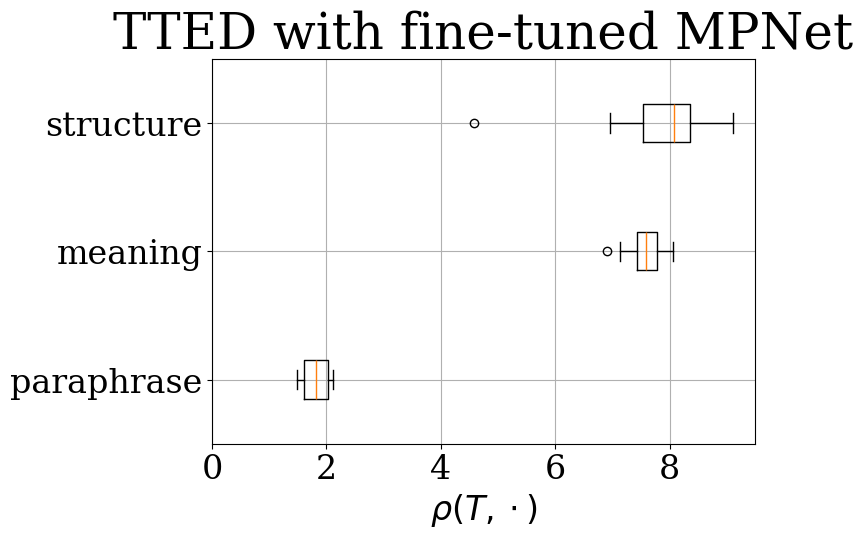

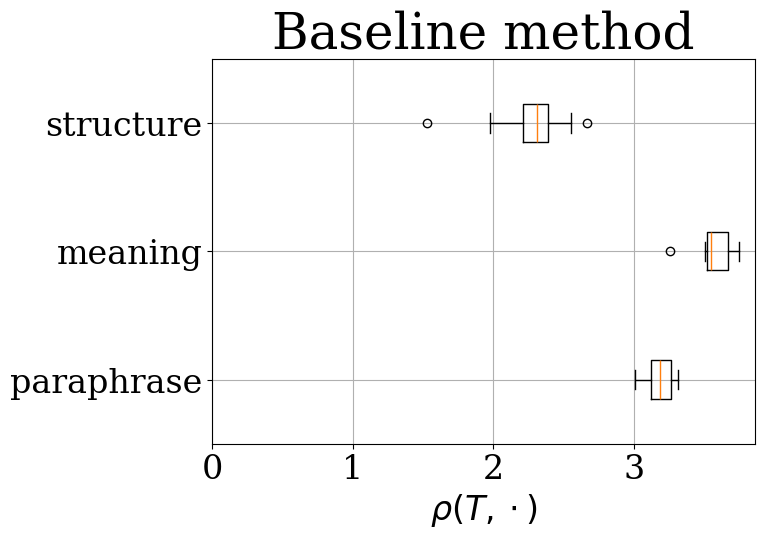

In [26]:
plot_scores(scores_dict['sentence-transformers/paraphrase-multilingual-mpnet-base-v2'], 
            'TTED with fine-tuned MPNet',
            '../paper/img/paraphrase_mpnet_results.png')
plot_scores(scores_dict['baseline'], 'Baseline method', '../paper/img/baseline_results.png')

## Computation time measurement

Here, we measure the time that it takes to compute TTED and the baseline similarity score for full binary text trees of depths 2 to 6 to see how the two methods scale.

In [11]:
n_range = np.arange(2, 8+1)

def measure_time(func):
    times = {}
    for n in tqdm(n_range):
        times[n] = []
        trees = []
        for i in range(5):
            trees.append(json_to_node(f'data/tted_time_test/depth_{n}/map_{i}.json'))
                                      
        for i in range(4):
            for j in range(i+1, 5):
                start_time = time.time()
                func(trees[i], trees[j])
                times[n].append(time.time() - start_time)
                
    return times

In [12]:
times_dict = {}

model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')
def cos_dist(a_embedding, b_embedding):
        return float(1 - model.similarity(a_embedding, b_embedding))

funcs = [
    baseline_similarity,
    lambda a, b: text_tree_distance(a, b, model.encode, cos_dist)
        ]

for i in range(len(funcs)):
    times_dict[i] = measure_time(funcs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:31<00:00, 38.80s/it]


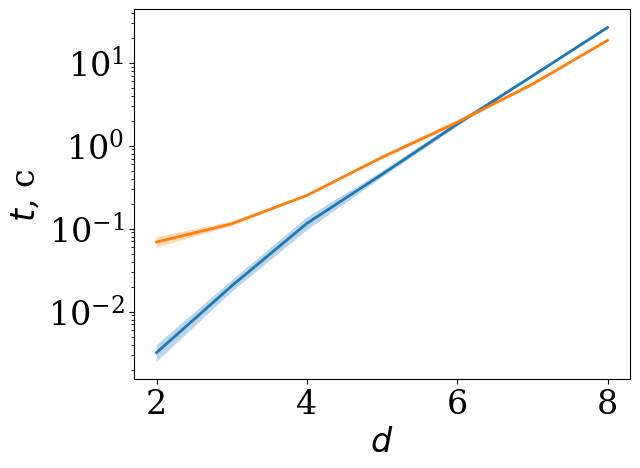

In [15]:
for i in range(len(funcs)):
    means = np.array([np.mean(measurement) for measurement in times_dict[i].values()])
    stds = np.array([np.std(measurement) for measurement in times_dict[i].values()])
    plt.plot(n_range, means)
    plt.fill_between(n_range, means - stds, means + stds, alpha=0.3)

plt.xlabel(r'$d$')
plt.ylabel(r'$t$, с')
plt.yscale('log')
plt.show()